In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.constants import *
import sys
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
from scipy.optimize import curve_fit

from mpl_toolkits.mplot3d import Axes3D
from colour import Color

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
%matplotlib inline

The following cell contains all of the parameters necessary to run the integration of the system

In [258]:
KmDhaTH = 0.77 #Km for H in N + H <--> D + P
KmDhaTN = 0.03 #Km for N in N + H <--> D + P
KiDhaTD = 0.23 #Ki for D in N + H <--> D + P
KiDhaTP = 7.4  #Ki for P in N + H <--> D + P
VfDhaT = 86.2  #V_f for N + H <--> D + P

KmDhaBG = 1.0 #Km for G in G <--> H
KiDhaBH = 1.0 #Km for H in G <--> H
VfDhaB = 1.0 #Vf for G <--> H

KmIcdEN = 1.0 #Km for N in N + A <--> I + D
KmIcdEA = 1.0 #Km for A in N + A <--> I + D
KiIcdED = 1.0 #Ki for D in N + A <--> I + D
KiIcdEI = 1.0 #Ki for I in N + A <--> I + D
VfIcdE = 1.0 #Vf for N + A <--> I + D

T = 298 # room temperature in kelvin
R =  8.314 # gas constant
DeltaGDhaT = -35.1/(R*T) # using Ph 7.8 since the IcdE reaction is forward processing
DeltaGDhaB = -18.0/(R*T) # using Ph 7.8 since the IcdE reaction is forward processing
DeltaGIcdE = -11.4/(R*T) # using Ph 7.8 since the IcdE reaction is forward processing

# cell and MCP constants
perm_cell = 1.0
perm_mcp= 1.0 
Vratio = 10
ngrid = 100
Rc = 1.e-5 #Radius of compartment (cm)
Diff = 1.e-4 #Diffusion coefficient
Rb = 5.e-5 #Effective Radius of cell (cm)
D = Diff/(Rc**2)
r_mcp = 1. # why? 
r_cell = Rb/Rc # why?

In [259]:
# state space and time scaling
G0 = KmDhaBG
H0 = KmDhaTH
N0 = KmDhaTN
P0 = KiDhaTP
D0 = KiIcdED
A0 = KmIcdEA
I0 = KiIcdEI
t0 = 3*r_mcp/perm_mcp


#non-dimensional parameters
alpha1 = t0*VfDhaB*(1-np.exp(DeltaGDhaB))/G0
alpha2 = t0*VfDhaB*(1-np.exp(DeltaGDhaB))/H0
alpha3 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/H0
alpha4 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/N0
alpha5 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(N0*KmIcdEN)
alpha6 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/P0
alpha7 = t0*VfDhaT*(1-np.exp(DeltaGDhaT))/D0
alpha8 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(D0*KmIcdEN)
alpha9 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(I0*KmIcdEN)
alpha10 = t0*VfIcdE*KmDhaTN*(1-np.exp(DeltaGIcdE))/(A0*KmIcdEN)

beta1 = KmDhaTH/KiDhaBH
beta2 = KiIcdED/KiDhaTD
beta3 = KmDhaTN/KmIcdEN

0.03

In [260]:
# mcp parameters

n_compounds_mcp = 7
n_compounds_cell = 5

The following cell defines a function for the derivative of the states. The output of this derivative is a vector of the same length as the state vectors.

The derivative calculated here is for the unitless/rescaled version of the equations. This is due to the fact that all the units are significantly different orders of magnitude causing many issues with stability of the equations.

In [261]:
def SDeriv(x,t): #spatial derivative
    
    ### why this scaling ####
    M_cell = (Rb/Rc)**3/3. # why?
    M_mcp = 1./3. # why?
    M = M_mcp
    DeltaM = np.divide((M_cell-M_mcp),(ngrid))
    
    ### why this scaling ####
    
    assert len(x) == 5*(2+(ngrid)) + 2 
    
    d = np.zeros((len(x)))
    
    
    ###################################################################################
    ################################## MCP reactions ##################################
    ###################################################################################
    
    R_DhaB = x[0]/(1+x[0]+x[1]*beta1)
    R_DhaT = x[1]*x[5]/(1+x[1]*x[5]+beta2*x[2]*x[6])
    R_IcdE = x[4]*x[5]/(1+x[4]*x[5]+beta3*x[3]*x[6])
    
    d[0] = -alpha1*R_DhaB + x[0+n_compounds_mcp] - x[0]                 #microcompartment equation for G
    d[1] = alpha2*R_DhaB - alpha3*R_DhaT + x[1+n_compounds_mcp] - x[1]  #microcompartment equation for H
    d[2] = alpha6*R_DhaT + x[2+n_compounds_mcp] - x[2]                  #microcompartment equation for P
    d[3] =  - alpha9*R_IcdE + x[3+n_compounds_mcp] - x[3]               #microcompartment equation for I
    d[4] = alpha9*R_IcdE + x[4+n_compounds_mcp] - x[4]                  #microcompartment equation for A
    
    d[5] = -alpha4*R_DhaT + alpha5*R_IcdE                                #microcompartment equation for N
    d[6] = alpha7*R_DhaT - alpha8*R_IcdE                                 #microcompartment equation for D



    ####################################################################################
    ##################################### boundary of MCP ##############################
    ####################################################################################
    
    M = M_mcp
    for i in range(7,12):        
        first_coef =  (3**(4./3.))*(D/(DeltaM)**2)*((((M + 0.5*DeltaM)**4)**(1/3.)) 
                                                    + (((M - 0.5*DeltaM)**4)**(1/3.)))
        second_coef = (perm_mcp*(M - 0.5*DeltaM)*3**(2./3.))/(DeltaM*M_mcp**(2/3))
        
        # BC at MCP for the ith compound in the cell 
        d[i] = first_coef*(x[i+n_compounds_cell]-x[i]) - second_coef*(x[i] - x[i-n_compounds_mcp]) 

    
    ####################################################################################
    ##################################### interior of cell #############################
    ####################################################################################
    
    for k in range(2,(ngrid+1)): 
        start_ind = 7 + (k-1)*n_compounds_cell
        end_ind =  7 + k*n_compounds_cell
        M += DeltaM # updated M
        #cell equations for ith compound in the cell 
        for i in range(start_ind,end_ind):
            coef = t0*((3**(4./3.))*D/(DeltaM)**2)
            d[i] = coef*((((M + 0.5*DeltaM)**4)**(1/3.))*(x[i+n_compounds_cell]-x[i]) 
                         - (((M - 0.5*DeltaM)**4)**(1/3.))*(x[i]-x[i-n_compounds_cell]))

    ####################################################################################
    ###################### boundary of cell with external volume #######################
    ####################################################################################
    
    M = M_cell
    for i in reversed(range(-6,-11,-1)):
        first_coef = t0*(3**(4./3.))*(D/(DeltaM)**2)*((((M + 0.5*DeltaM)**4)**(1/3.)) + (((M - 0.5*DeltaM)**4)**(1/3.)))
        second_coef = t0*(perm_cell*(M_cell + 0.5*DeltaM)*3**(2./3.))/(DeltaM*M_cell**(2/3))
        
        # BC at ext volume for the ith compound in the cell 
        d[i] = first_coef*(x[i-n_compounds_cell] - x[i]) - second_coef*(x[i] - x[i+n_compounds_cell])
        
    
    #####################################################################################
    ######################### external volume equations #################################
    #####################################################################################
    for i in reversed(range(-1,-6,-1)):
        d[i] = t0*(3*perm_cell/r_cell)*(x[i - n_compounds_cell] - x[i])/(Vratio) #external equation for A
    return d

In [273]:
SInit = 700.
y0 = np.zeros((ngrid+2)*n_compounds_cell+2)
y0[-5] = SInit/G0 #y0[-5] gives the initial state of the external substrate. The /G0 turns the value into a dimensionless quantity
timeorig = np.linspace(0,1e10,1e5)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


In [274]:
sol = odeint(SDeriv, y0, timeorig)

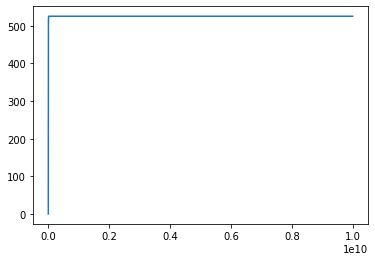

In [297]:
plt.plot(timeorig,sol[:,-4])
plt.show()

In [77]:
no_mcp_sol = sol[:,7:] # mass conservations? check stoichiometries
# there does not seem to be an accumulation of H

In [85]:
#2*no_mcp_sol[:,list(range(1,130,5))].sum(axis=1)

array([0., 0., 0., ..., 0., 0., 0.])

#### The next few cells are used only if you have not generated/saved data already

The following cell calculates the time series going forward for a grid of permeabilities. Each set of permeabilities uses the same time points and is integrated for the same amount of time.

This causes poor resolution for the faster paths. The results of this cell will be used to determine the time necessary to properly resolve each set of parameter values for when the "progress" calculation is done

In [9]:
sol = np.zeros((51,51,1000,3*(ngrid+2)))
values = np.linspace(-6,-3,51)

for i in (range(51)):
    perm0c = 10**(values[i])
    perm1c = perm0c
    perm2c = perm0c
    for j in (range(51)):
        a = sys.stdout
        a.write('\r')
        a.write('[%-51s]      [%-51s]' % ('='*(i+1),'='*(j+1)))
        a.flush()
        perm0b = 10**(values[j]+1)
        perm1b = perm0b
        perm2b = perm0b
        sol[i,j] = odeint(SDeriv, y0, timeorig)

[============================================       ]      [=============================================      ]

/home/ash4334/.local/lib/python2.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


[===================================================]      [===================================================]

In [23]:
np.save('WildType/States-SameTime.npy',sol) #Saving the data from the previous cell

The following cell takes the data from the previous integration and determines the time at which each parameter set reaches 95% of the equilibrium value of the final product. This time is then multiplied by 2 and used as the new end point for the time series. This adjustment allows you to adjust the resolution of the time series to the time it takes to reach equilibrium.

In [66]:
EquilibriumTime = np.zeros((51,51))
for i in range(51):
    for j in range(51):
        complete = np.where(sol[i,j,:,-1]*Kscale[-1]>=0.95*SInit*0.5*(10./11.))
        if len(complete[0])>0:
            EquilibriumTime[i,j] = timeorig[np.min(complete[0])]*2
        else:
            EquilibriumTime[i,j] = timeorig[-1]*5

Using the end point defined in the previous cell, the next one solves for the full time series up to that time for each parameter set. This set of data is then going to be converted into (progress, concentration) series - instead of (time, concentration). Because each path stops around equilibrium and is well resolved throughout the progress of the path we are able to get enough resolution in progress space for all parameter sets

In [67]:
rescaledsol = np.zeros((51,51,1000,3*(ngrid+2)))
Times = np.zeros((51,51,1000))

for i in (range(51)):
    perm0c = 10**(values[i])
    perm1c = perm0c
    perm2c = perm0c
    for j in (range(51)):
        Time = np.linspace(0,EquilibriumTime[i,j],1000)
        Times[i,j] = Time
        a = sys.stdout
        a.write('\r')
        a.write('[%-51s]      [%-51s]' % ('='*(i+1),'='*(j+1)))
        a.flush()
        perm0b = 10**(values[j]+1)
        perm1b = perm0b
        perm2b = perm0b
        rescaledsol[i,j] = odeint(SDeriv, y0, Time)

[===================================================]      [===================================================]

In [68]:
np.save('WildType/States-ScaledTime.npy',rescaledsol)
np.save('WildType/ScaledTimes.npy',Times)
#This cell saves both the Time series and the times at which the data is collected for all parameter sets

The next cell is used if you already have saved time series

If you do not want to take the time to integrate the dynamics above - or you have already done this and saved the data, you can load the data series in the next cell

In [ ]:
rescaledsol = np.load('WildType/States-ScaledTime.npy')
Times = np.load('WildType/ScaledTimes.npy')
sol = np.load('WildType/States-SameTime.npy')

From now on all cells are used regardless of if you have previously generated data or not.

In [335]:
#Create a grid of parameter values - This will be used later to define the grid when plotting the model surface 

kc = np.zeros((51,51))
kb = np.zeros((51,51))

for i in (range(51)):
    for j in (range(51)):
        kc[i,j] = 10**(values[i])
        kb[i,j] = 10**(values[j]+1)

The next few cells are used to define progress and calculate split the data points into progress "bins"

\begin{equation}p = \frac{2 m_\perp P_{ext} - S_{ext} + S_0}{S_0(1+m_\perp^2)}\end{equation}

Here $m_\perp \equiv \frac{V_{ratio}}{1+V_{ratio}}$

Then $D_{\perp}$ is defined as the distance from the point of the path in (P,S) space to the line that connects the initial and final points of the path in (P,S) space

\begin{equation}
D_\perp = \sqrt{4 P_{ext}^2 + (S_{ext} - S_0)^2 - [l(S_{ext},P_{ext},S_0)]^2} \end{equation}

where we define
\begin{equation} l(S_{ext},P_{ext},S_0) = \frac{2 m_\perp P_{ext} - S_{ext} +S_0}{\sqrt{1+m_\perp^2}}\end{equation}

In [183]:
def p(S,P,S0):
    mperp = np.divide(np.float(Vratio),np.float(Vratio)+1.)
    return np.divide(2*mperp*P - S + S0,S0*(1+mperp**2))

def l(S,P,S0):
    mperp = np.divide(np.float(Vratio),np.float(Vratio)+1.)
    return np.divide(2*mperp*P - S + S0,np.sqrt(1+mperp**2))
    

def Dperp(S,P,S0):
    mperp = np.divide(np.float(Vratio),np.float(Vratio)+1.)
    return np.sqrt(4*P**2 + (S-S0)**2 - l(S,P,S0)**2)

The next cell calculates the progress and $D_\perp$ values for each time point for each parameter set using the scaled time set

In [184]:
progressvalues = np.zeros((51,51,1000))
Disp = np.zeros((51,51,1000))

for i in range(51):
    for j in range(51):
        progressvalues[i,j] = p(rescaledsol[i,j,:,-3]*Kscale[0],rescaledsol[i,j,:,-1]*Kscale[2],SInit)
        Disp[i,j] = Dperp(rescaledsol[i,j,:,-3]*Kscale[0],rescaledsol[i,j,:,-1]*Kscale[2],SInit)

The next cell creates a list called "ByProgress" the i'th element of this list is the set of all points in $(Intermediate,D_\perp)$ space that exist between the i'th and (i+1)'st percentage values of progress.

Because some paths are more resolved or take longer in certain regions than others, you get that there are often multiple time points from a single path that land in the same progress set. This should be fine because they are close to one another and should not add too much excess variation when doing PCA

In [185]:
ByProgress = []
for i in np.arange(0,1,0.01):
    placeholder = rescaledsol[:,:,:,-3:][np.where(np.logical_and(progressvalues>=i,progressvalues<i+0.01))]*Kscale
    placeholderInt = placeholder[:,1]
    placeholderD = Dperp(placeholder[:,0],placeholder[:,2],SInit)
    placeholder2 = np.array([placeholderInt,placeholderD])
    ByProgress.append(placeholder2)

In the following cell we take each element in the "ByProgress" list - remember, these are a set of 2-D points - and calculate PCA on them. This gives us the variation in the $D_\perp$ and Intermediate metabolite at each progress value.

The eigenvectors, eigenvalues, and eigenvalue ratios are all saved for each progress value.

We then plot the eigenvalues over progress to show how the variation changes as the dynamics progress

In [528]:
progressPCA = np.array([0])
pca = sklearnPCA()
PCA_Vectors = []
PCA_Values = []
PCA_Ratios = []
for i in range(1,100):
    if len(ByProgress[i][0]>0):
        progressPCA = np.vstack([progressPCA,i])
        X = ByProgress[i].T
        pca.fit(X)
        PCA_Vectors.append(pca.components_)
        PCA_Values.append(pca.explained_variance_)
        PCA_Ratios.append(pca.explained_variance_ratio_)
        
progressPCA = np.reshape(progressPCA[1:],-1)
PCA_Vectors = np.asarray(PCA_Vectors)
PCA_Values = np.asarray(PCA_Values)
PCA_Ratios = np.asarray(PCA_Ratios)

plt.plot(progressPCA,PCA_Values[:,0])
plt.plot(progressPCA,PCA_Values[:,1])
plt.xlabel('progress')
plt.ylabel('Eigenvalues')
plt.show()

In [530]:
#Plot of all dimensions with  progress as independent variable. This is to help visualize the space in progress
#instead of time.

colors = ['#332288', '#88CCEE', '#117733','#DDCC77', '#CC6677','#AA4499']

plt.suptitle('States vs Progress',fontsize = 20)

plt.subplot(221)
for i in range(0,51,5):
    for j in range(0,51,5):
        plt.plot(progressvalues[i,j]*100,rescaledsol[i,j,:,-2]*Kscale[1],colors[0])
plt.axvline(x=progressPCA[np.argmax(PCA_Values[:,0])],color = 'k')
plt.ylabel('Intermediate Metabolite\nConcentration',fontsize = 15)
        
plt.subplot(222)
for i in range(0,51,5):
    for j in range(0,51,5):
        plt.plot(progressvalues[i,j]*100,Disp[i,j],colors[1])
plt.axvline(x=progressPCA[np.argmax(PCA_Values[:,0])],color = 'k')
plt.ylabel('Distance from\nProgress Metric',fontsize = 15)
        
plt.subplot(223)
for i in range(0,51,5):
    for j in range(0,51,5):
        plt.plot(progressvalues[i,j]*100,rescaledsol[i,j,:,-3]*Kscale[0],colors[2])
plt.axvline(x=progressPCA[np.argmax(PCA_Values[:,0])],color = 'k')
plt.ylabel('Substrate Metabolite\nConcentration',fontsize = 15)
plt.xlabel('Progress',fontsize = 15)
        
plt.subplot(224)
for i in range(0,51,5):
    for j in range(0,51,5):
        plt.plot(progressvalues[i,j]*100,rescaledsol[i,j,:,-1]*Kscale[2],colors[4])
plt.axvline(x=progressPCA[np.argmax(PCA_Values[:,0])],color = 'k')
plt.ylabel('Product Metabolite\nConcentration',fontsize = 15)
plt.xlabel('Progress',fontsize = 15)
        
plt.tight_layout()      
plt.show()

We now take the data that was originally collected at all the same time points (This is the first set of data that was made) and look at the variation of the three metabolite concentrations over time.

Because the product is split between 2 different products and it appears (if you didn't know that there were 2 products) that the product somehow managed to make half the mass disappear, we run PCA in $(S,I,2P)$ space. This also allows us to  make sure that the fact that the scale of the product being half the scale of the other two metabolites doesn't affect the results

We again plot the eigenvalues over time to show that there is a peak in eigenvalue and variability

*Note*: In this case we have a 3d space while in the progress case we have a 2d space. This is because when we choose to have progress as our independent variable, the S and P variables are now coupled and not independent - since their relationship defines progress

In [531]:
PCA_T_Vectors = []
PCA_T_Values = []
PCA_T_Ratios = []

for t in range(0,len(timeorig)):
    x1 = np.reshape(sol[:,:,t,-3]*Kscale[0],(-1))
    x2 = np.reshape(sol[:,:,t,-2]*Kscale[1],(-1))
    x3 = 2*np.reshape(sol[:,:,t,-1]*Kscale[1],(-1))
    X = np.array([x1,x2,x3]).T
    pca.fit(X)
    PCA_T_Vectors.append(pca.components_)
    PCA_T_Values.append(pca.explained_variance_)
    PCA_T_Ratios.append(pca.explained_variance_ratio_)

PCA_Time = timeorig
PCA_T_Vectors = np.asarray(PCA_T_Vectors)    
PCA_T_Values = np.asarray(PCA_T_Values)    
PCA_T_Ratios = np.asarray(PCA_T_Ratios)

plt.plot(PCA_Time,PCA_T_Values[:,0])
plt.plot(PCA_Time,PCA_T_Values[:,1])
plt.plot(PCA_Time,PCA_T_Values[:,2])
plt.show()

In [533]:
#Here we plot several paths to show how the parameter values affect the time series. The black line marks the time at
#which we have the largest eigenvalue

colors = ['#332288', '#88CCEE', '#117733','#DDCC77', '#CC6677','#AA4499']

plt.suptitle('States vs Time',fontsize = 20)

plt.subplot(221)
for i in range(0,51,5):
    for j in range(0,51,5):
        plt.plot(timeorig,sol[i,j,:,-2]*Kscale[1],colors[0])
plt.axvline(x=PCA_Time[np.argmax(PCA_T_Values[:,0])],color = 'k')
plt.ylabel('Intermediate Metabolite\nConcentration',fontsize = 15)
        
plt.subplot(222)
for i in range(0,51,5):
    for j in range(0,51,5):
        plt.plot(timeorig,sol[i,j,:,-3]*Kscale[0],colors[2])
plt.axvline(x=PCA_Time[np.argmax(PCA_T_Values[:,0])],color = 'k')
plt.ylabel('Substrate Metabolite\nConcentration',fontsize = 15)
plt.xlabel('Time',fontsize = 15)
        
plt.subplot(223)
for i in range(0,51,5):
    for j in range(0,51,5):
        plt.plot(timeorig,sol[i,j,:,-1]*Kscale[2],colors[4])
plt.axvline(x=PCA_Time[np.argmax(PCA_T_Values[:,0])],color = 'k')
plt.ylabel('Product Metabolite\nConcentration',fontsize = 15)
plt.xlabel('Time',fontsize = 15)
        
plt.tight_layout()      
plt.show()

Now that we have finished calculating PCA for both time and progress space, we analyze these results.

First Progress:

We want to find the point at which the progress of each path corresponds to the highest eigenvalue. This particular point in the path will be used as an observation. We will choose 1 path to be the "truth" and will calculate the error surface between this "true" path and all the others using just the most first eigenvector of the most variable progress point for each eigenvalue.

Since the progress is not calculated at exactly the same points, we need to determine what the progress is at the points closest to the most variable progress point. And look up the value of the states at those points.

We also want to look at just the first eigenvector, in progress space because if we look at the eigenvalue decomposition, the first eigenvector contains close to 100% of the variation

Choose a path to be our "True" Path. This will be an index for the parameters that we want to  be the correct value we will compare to. I've chosen indices that approximately match what we expect the permeabilities to be.

This truth value will be the same for all analysis used

In [538]:
truth_index = (15,34)

In [534]:
#Find the progress value at which the eigenvalue is largest
VarProg = progressPCA[np.argmax(PCA_Values[:,0])]*0.01 #this is as a fraction
VarProgPercent = progressPCA[np.argmax(PCA_Values[:,0])] #This is a percentage and an index to be plugged into the arrays

In [535]:
#Find the point in each time series that ends up with the closest progress to the one picked out by PCA

closestProg = np.zeros((51,51))
locProg = np.zeros((51,51))

for i in range(51):
    for j in range(51):
        loc = np.argmin((progressvalues[i,j]-VarProg)**2)
        closestProg[i,j] = (progressvalues[i,j,loc])
        locProg[i,j] = np.int(loc)

In [536]:
#Create the vectors of (Intermediate,Dperp) coordinates for the points corresponding to the highest variability in progress

Data_Var_Prog = np.zeros((51,51,2))

for i in range(51):
    for j in range(51):
        time_of_prog = int(locProg[i,j])
        Data_Var_Prog[i,j] = np.array([rescaledsol[i,j,time_of_prog,-2]*Kscale[1],Disp[i,j,time_of_prog]])
Data_Var_Prog_reshape = np.reshape(Data_Var_Prog,(51*51,2))

In [537]:
#Calculate the the length of both eigenvectors using the (Int,Dperp) data points and the eigenvectors found in PCA

PCA_Var_Vec_reshape = np.array([np.dot(Data_Var_Prog_reshape,PCA_Vectors[VarProgPercent,0]),np.dot(Data_Var_Prog_reshape,PCA_Vectors[VarProgPercent,1])])
PCA_Var_Vec = np.array([np.dot(Data_Var_Prog,PCA_Vectors[VarProgPercent,0]),np.dot(Data_Var_Prog,PCA_Vectors[VarProgPercent,1])])

In [539]:
#Calculate error between First eigenvector length for progress PCA as compared to the "true" path. This is a percent
#error and is calculated by a difference divided by the length of the true path eigenvector
PCA_Error = np.divide(np.absolute(PCA_Var_Vec[(0,) + truth_index] - PCA_Var_Vec[0]),np.absolute(PCA_Var_Vec[0]))

In [540]:
#Plot the error calculated above as a heat map. The white star corresponds to the "true" path. The white contour
#corresponds to 1% error

cont = plt.pcolormesh(kc,kb,PCA_Error,norm = matplotlib.colors.LogNorm(),shading = 'gouraud',cmap = 'magma')
plt.scatter(kc[truth_index],kb[truth_index],marker = '*',color = 'white')
plt.contour(kc,kb,PCA_Error,levels = [0.1])
plt.xscale('log')
plt.yscale('log')
plt.colorbar(cont,label = 'Percent Error Compared to "Truth"')
plt.ylabel('Cell Permeability')
plt.xlabel('MicroCompartment Permeability')
plt.title('Error Plot Using Most Variable Progress Value')
plt.show()

We do the same error calculation  using the  most variable time point instead of progress. Again, only using the first eigenvector

In [544]:
#Find the time point at which the eigenvalue is largest when doing PCA over time
#Collect a set of data points in (S,I,2P) for that specific time value

#NOTE: It is important that you save 2*P as your last dimension in the data points because that is what PCA was done using
#And your eigenvector has 2*P as one of the dimensions, NOT just P

Data_Var_Time = np.zeros((51,51,3))

PCATimeIndex = np.argmax(PCA_T_Values[:,0])

for i in range(51):
    for j in range(51):
        Data_Var_Time[i,j] = np.array([sol[i,j,PCATimeIndex,-3]*Kscale[0],sol[i,j,PCATimeIndex,-2]*Kscale[1],2*sol[i,j,PCATimeIndex,-1]*Kscale[2]])
Data_Var_Time_reshape = np.reshape(Data_Var_Time,(51*51,3))

Time_Var_Vec = np.array([np.dot(Data_Var_Time,PCA_T_Vectors[PCATimeIndex,0]),np.dot(Data_Var_Time,PCA_T_Vectors[PCATimeIndex,1]),np.dot(Data_Var_Time,PCA_T_Vectors[PCATimeIndex,2])])


In [545]:
#Calculate a percent error again for the first eigenvector between the "true" path and the grid of parameters

Time_Error = np.divide(np.absolute(Time_Var_Vec[(0,) + truth_index] - Time_Var_Vec[0]),np.absolute(Time_Var_Vec[0]))

In [546]:
#Plot the error manifold - "true" path is again the white star and the 1% error curve is the white contour

cont = plt.pcolormesh(kc,kb,Time_Error,norm = matplotlib.colors.LogNorm(),shading = 'gouraud',cmap = 'magma')
plt.contour(kc,kb,Time_Error,levels = [0.1],colors = 'white')
plt.scatter(kc[truth_index],kb[truth_index],marker = '*',color = 'white')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(cont,label = 'Percent Error Compared to "Truth"')
plt.ylabel('Cell Permeability')
plt.xlabel('MicroCompartment Permeability')
plt.title('Error Plot Using Most Variable Time Value')
plt.show()

We now do an error calculation for the full time series.

In this case there is no manipulation of the product value, we're just using the "raw" output of the measurements to compare the curves

One constraint is the selection of time points at which to do this analysis. Since the integration generated 1000 time points for each path (and this is extremely unrealistic for an experiment) I have subsampled down to 2 data points.
In addition I have subsampled in such a way that the time points are chosen so that the "true" path (or data when we have real data) is well resolved. Meaning, the end point is about where the true path reaches equilibrium and we don't have a bunch of data sitting at steady state. This is done because collecting a lot of steady state data makes it harder to differentiate paths (since they all reach the same steady state) and because it is not realistic for us to continue running the experiment once the system has reached steady state.

You can play around with the chosen times to see the effect of choosing different time points

In [547]:
#The error is calculated by setting the collected data to a T*3-dimensional vector (where T is the number of time points)
#Then we take the difference between the "true" and estimated paths. The magnitude of this vector is calculated and scaled
#by the magnitude of the vector for the "true" path. This gives a percent error between the two paths

Series_Error = np.divide(np.sqrt(np.sum(np.square((sol[:,:,:80:4,-3:]-sol[truth_index][:80:4,-3:])*Kscale),axis = (2,3))),np.sqrt(np.sum(np.square((sol[truth_index][:80:4,-3:]*Kscale)))))

In [548]:
#Plot heat map of entire series error - star is "true" - contour is 1% error

cont = plt.pcolormesh(kc,kb,Series_Error,norm = matplotlib.colors.LogNorm(),shading = 'gouraud',cmap = 'magma')
plt.contour(kc,kb,Series_Error,levels = [0.1],colors = 'white')
plt.scatter(kc[truth_index],kb[truth_index],marker = '*',color = 'white')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(cont,label = 'Percent Error Compared to "Truth"')
plt.ylabel('Cell Permeability')
plt.xlabel('MicroCompartment Permeability')
plt.title('Error Plot Using Full Time Series')
plt.show()

In [549]:
#Combine all error maps together - All are plotted using the same colorbar and scale.
#You can see that the most variable progress value constrains a smaller region than the most variable time point

#You can also see that the "good" region chosen by the most variable progress value does just as well as the good region
#using the whole time series. If different time points are chosen for the whole time series, the region may become more
#poorly constrained than. The progress value calculation uses just one well chosen time point and contains the same
#amount of information as the whole path

plt.suptitle('Error Heat Map Using',fontsize = 20)

plt.subplot(131)
cont = plt.pcolormesh(kc,kb,PCA_Error,norm = matplotlib.colors.LogNorm(vmin=10**(-4.8), vmax=10**(2.3)),shading = 'gouraud',cmap = 'magma')
plt.scatter(kc[truth_index],kb[truth_index],marker = '*',color = 'white')
plt.contour(kc,kb,PCA_Error,levels = [0.1],colors = 'white')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Cell Permeability',fontsize = 18)
plt.title('Most Variable\nProgress Value',fontsize = 18)

plt.subplot(132)
cont = plt.pcolormesh(kc,kb,Time_Error,norm = matplotlib.colors.LogNorm(vmin=10**(-4.8), vmax=10**(2.3)),shading = 'gouraud',cmap = 'magma')
plt.contour(kc,kb,Time_Error,levels = [0.1],colors = 'white')
plt.scatter(kc[truth_index],kb[truth_index],marker = '*',color = 'white')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('MicroCompartment Permeability',fontsize = 18)
plt.title('Most Variable\nTime Value',fontsize = 18)

plt.subplot(133)
cont = plt.pcolormesh(kc,kb,Series_Error,norm = matplotlib.colors.LogNorm(vmin=10**(-4.8), vmax=10**(2.3)),shading = 'gouraud',cmap = 'magma')
plt.contour(kc,kb,Series_Error,levels = [0.1],colors = 'white')
plt.scatter(kc[truth_index],kb[truth_index],marker = '*',color = 'white')
plt.colorbar(cont,label = 'Percent Error Compared to "Truth"')
plt.xscale('log')
plt.yscale('log')
plt.title('Full Time Series\n(Subsampled-20 time points)',fontsize = 18)


plt.show()

The following cells attempt the integrate in terms of progress as an independent variable. This will lose all concept of time and the conversion back to time space will not be possible. On the above cells the integration is done in time. Based on a derivation for the "progress" variable, we can convert every x-t plot to an x-p plot (where x is a placeholder for a generic state in the system).

To define progress we first set up our coordinates in the (2 * external Product,external Substrate) plane. We choose the factor of 2 in the x-coordinate because for this *specific* case, the product concentration is split into 2 products of equal concentration. We take into account that there is no loss of mass by doubling the final product. There should not be any difference in the final results if we don't use that factor of 2. We just need to  make sure to calculate all the terms (including slope and final states) correctly if this 2 is not included. Note that for a reversible reaction at time = 0 we start at $(0,S_0)$. And at time = equilibrium time we end at $(2 * P_f,0)$. If there is a ratio of $m_\perp = \frac{V_{ext}}{V_{ext}+V_{cell}}$ between the outside concentration and the total solution concentration, then we get $2\cdot P_f = S_0 \cdot m_\perp$

Then the line connecting the initial and final states of the system is the straight line from $(0,S_0) \rightarrow (m_\perp\cdot S_0,0)$.

We define the progress variable as a parametrization along this line that is equally distributed. The progress of a generic point $(2\cdot P_{ext},S_{ext})$ is then given by projecting this curve onto the "progress line" in $(2\cdot P_{ext},S_{ext})$ space and determining what fraction, $p$, of the way from the initial to final points this curve lies.

Following some algebra, you get that the progress of a point can be calculated from its product and substrate values:

\begin{equation}p = \frac{2 m_\perp P_{ext} - S_{ext} + S_0}{S_0(1+m_\perp^2)}\end{equation}

We can then calculate the change in progress over time:

\begin{equation}\dot p = \frac{1}{S_0(1+m_\perp^2)} \left[2 m_\perp \dot P_{ext} - \dot S_{ext}\right]\end{equation}

If we wish to covert our differential equations in time to equations in $p$ we can apply the chain rule. Define $\mathbf{X}$ as the vector of state values and $\dot{\mathbf{X}} = \mathbf{F}(\mathbf{X})$. Then 

\begin{gather}
\dot{\mathbf{X}} = \frac{d \mathbf{X}}{d p} \dot p\\
\frac{d \mathbf{X}}{d p} = \dot{\mathbf{X}}\cdot (\dot p)^{-1}\\
\frac{d \mathbf{X}}{d p} = \mathbf{F}(\mathbf{X}) \cdot (\dot p)^{-1}\\
\frac{d \mathbf{X}}{d p} = \frac{\mathbf{F}(\mathbf{X}) \cdot(S_0(1+m_\perp^2))}{2 m_\perp \dot P_{ext} - \dot S_{ext}}
\end{gather} 